In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import src.segnet_model as segnet_model
import src.segtools as segtools
from keras import optimizers
from glob import glob
import os
import json
from sklearn.metrics import confusion_matrix
import itertools
from PIL import Image
%matplotlib inline
%load_ext autoreload
%autoreload 2


Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
model_json = './fit_models/beta_v1_01/seg_net.json' 
model_weight = './fit_models/beta_v1_01/seg_net.h5' 
model = segnet_model.import_model(model_json, model_weight)
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', \
                     optimizer=opt, metrics=['categorical_accuracy'])
print('Model compiled!')

Model compiled!


In [4]:
# data type is wrong in validation
# get validation data to check things out
val_batch = len(glob('./images/val/a/*.png'))
val_generator = segtools.data_generator('/contents/images/val', batch_size=val_batch)
x_val, y_val = next(val_generator)
n_classes = 2
y_val, _ = segtools.post_process_y(y_val, n_classes)

In [5]:
pr = model.predict(x_val)
y_hat, y_pr = segtools.post_process_y(pr, n_classes)

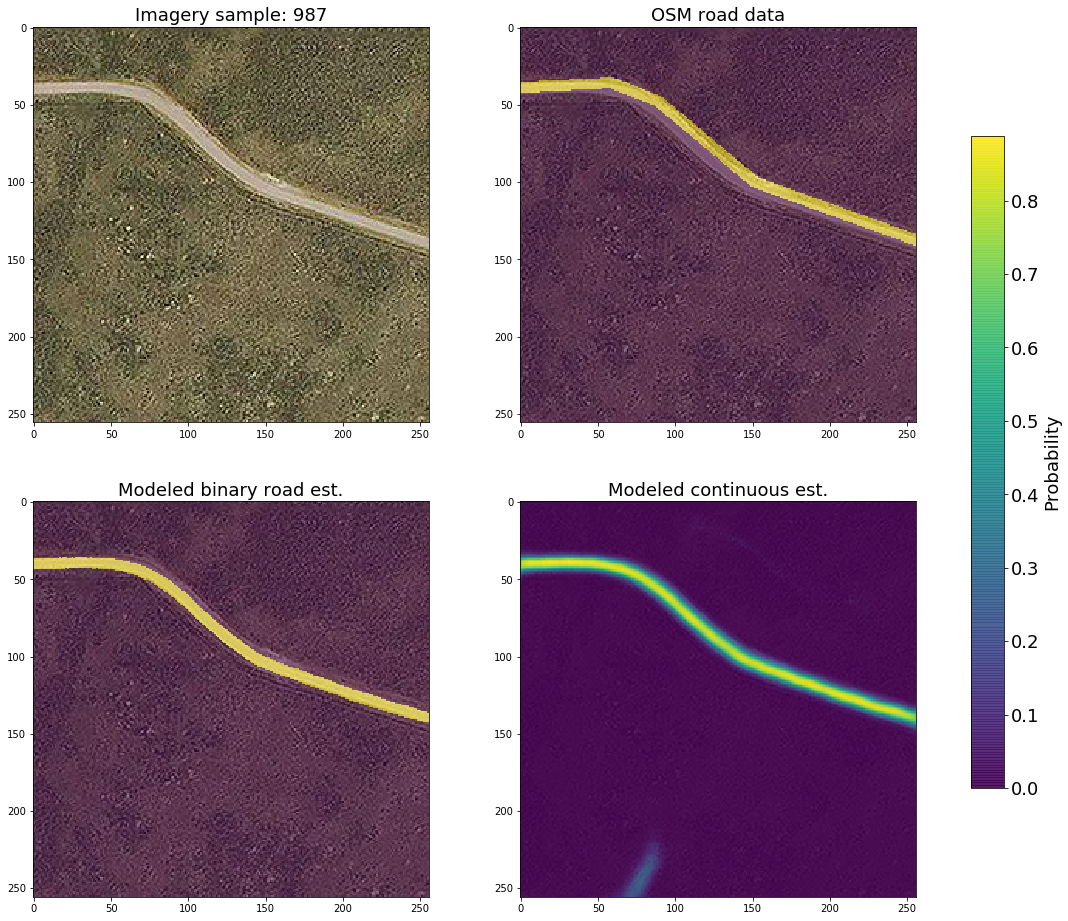

In [37]:
f, ax = plt.subplots(2,2, figsize=(20, 16))
sample = np.random.randint(0, len(x_val))
x_ = x_val[sample].astype('float32')
y_ = y_val[sample]
ax[0,0].imshow(x_)
ax[0,0].set_title('Imagery sample: %s'%sample,fontsize=18)
ax[0,1].imshow(x_)
ax[0,1].imshow(y_, alpha=0.5)
ax[0,1].set_title('OSM road data',fontsize=18)
ax[1,0].imshow(x_)
#binary classify the road surface

ax[1,0].imshow(x_)
ax[1,0].imshow(y_hat[sample], alpha=0.5)
ax[1,0].set_title('Modeled binary road est.',fontsize=18)

ax[1,1].imshow(x_)
im = ax[1,1].imshow(y_pr[sample][:,:,0], alpha=0.9)
ax[1,1].set_title('Modeled continuous est.',fontsize=18)
cb = f.colorbar(im, ax=ax.ravel().tolist(),shrink=0.75)
cb.ax.tick_params(labelsize=18)
cb.set_label('Probability', fontsize=18)
#f.savefig('./figures/example_quad_%s.png'%(sample), dpi=600, bbox_inches='tight')

Normalized confusion matrix
[[ 0.98027881  0.01972119]
 [ 0.603608    0.396392  ]]


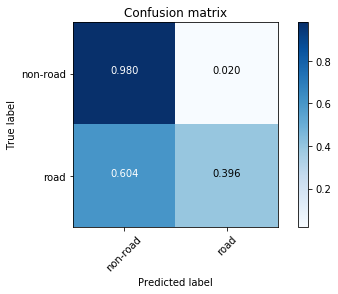

In [38]:
cnf_matrix = confusion_matrix(y_hat[sample].flatten(), \
                              y_val[sample].flatten())
plot_confusion_matrix(cnf_matrix, classes=['non-road', 'road'], title='Confusion matrix', normalize=True)
plt.savefig('./figures/val_confusion_matrix_sample_%s.png'%(sample)\
            , dpi=400, bbox_inches='tight')

In [39]:
divs = 100

precision = np.zeros(divs) 
recall = np.zeros(divs) 
f1 = np.zeros(divs) 
thr = np.linspace(0,1,divs)
for i in range(divs):
    mask = np.zeros(y_pr.shape[:3])
    mask[y_pr[:,:,:,0]>=thr[i]] = 1
    _, precision[i], recall[i], f1[i] = segtools.accuracy_summaries(y_val, mask)

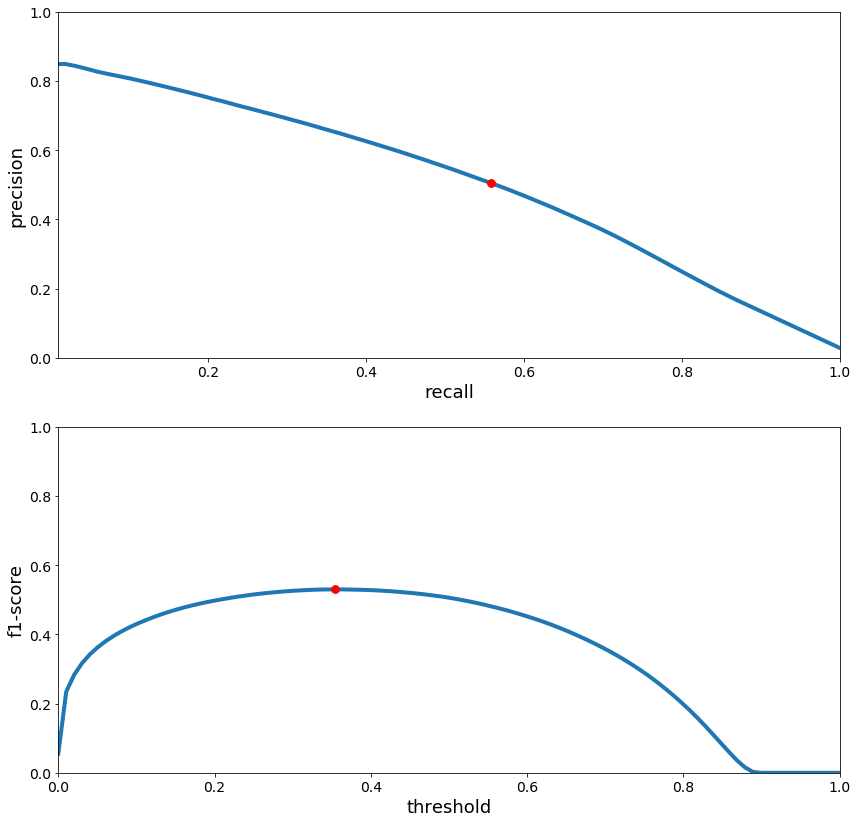

In [40]:
f, ax = plt.subplots(2,1,figsize=(14,14))
ax[0].plot(recall,precision, lw=4, zorder=1)
ax[0].scatter(recall[np.argmax(f1)], precision[np.argmax(f1)], color='red', s=60, zorder=2)
ax[0].set_xlim(0.01,1)
ax[0].set_ylim(0,1)
ax[0].set_xlabel('recall', fontsize=18)
ax[0].set_ylabel('precision',fontsize=18)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)
ax[1].plot(thr, f1, lw=4, zorder=1)
ax[1].scatter(thr[np.argmax(f1)], f1[np.argmax(f1)], color='red', s=60, zorder=2)
ax[1].set_xlim(0,1)
ax[1].set_ylim(0,1)
ax[1].set_ylabel('f1-score', fontsize=18)
ax[1].set_xlabel('threshold',fontsize=18)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)
#f.savefig('./figures/prec_recall.png', dpi=400, bbox_inches='tight')

precision: 0.396392003901, 
 recall: 0.393704600484, 
 f1-score: 0.395043731778


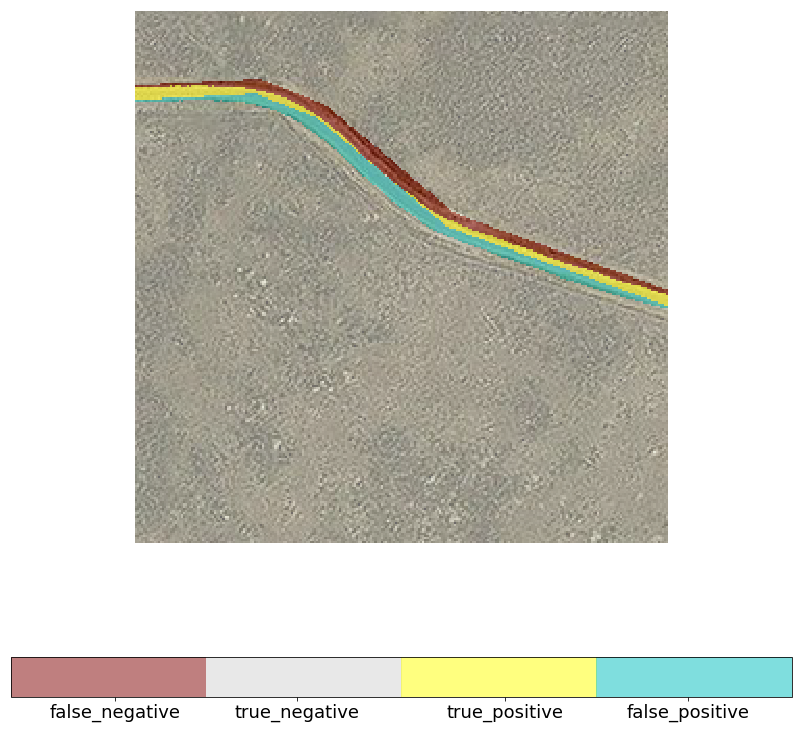

In [41]:
#N = 4

mac, precision, recall, f1 = segtools.accuracy_summaries(y_val[sample], y_hat[sample])
print('precision: %s, \n recall: %s, \n f1-score: %s'%(precision, recall, f1))
#print('precision: %s, \n recall: %s, \n f1-score: %s'%(precision2, recall2, f1))
f, ax = plt.subplots(1,1,figsize=(14,14))
ax.set_axis_off()
cmap = mpl.colors.ListedColormap(['maroon','lightgrey','yellow','c'])
ax.imshow(x_)
#ax[1].imshow(x_)
im = ax.imshow(mac, cmap=cmap, alpha=0.5)
#im2 = ax[1].imshow(mac2, cmap=cmap, alpha=0.5)
bounds = [0.4, 1.1, 1.9, 2.6]
labels = ['false_negative', 'true_negative', 'true_positive', 'false_positive']
cb = f.colorbar(im, orientation='horizontal')
cb.set_ticks(bounds)
cb.set_ticklabels(labels)
cb.ax.tick_params(labelsize=18)
#f.savefig('./figures/example_acc_out_sample_%s.png'%(sample), dpi=600, bbox_inches='tight')

In [42]:
cnf_matrix = confusion_matrix(y_hat.flatten(), y_val.flatten())

Normalized confusion matrix
[[ 0.98363199  0.01636801]
 [ 0.4012934   0.5987066 ]]


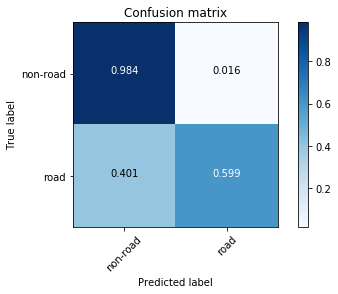

In [44]:
plot_confusion_matrix(cnf_matrix, classes=['non-road', 'road'], title='Confusion matrix', normalize=True)
#plt.savefig('./figures/val_confusion_matrix.png', dpi=600, bbox_inches='tight')

In [47]:
# data type is wrong in validation
# get validation data to check things out
test_batch = len(glob('./images/test/a/*.png'))
test_generator = segtools.data_generator('/contents/images/test', batch_size=test_batch)
x_test, y_test = next(test_generator)
n_classes = 2
y_test, _ = segtools.post_process_y(y_test, n_classes)
pr_test = model.predict(x_test)
y_hat_test, y_pr_test = segtools.post_process_y(pr_test, n_classes)
cnf_matrix = confusion_matrix(y_hat_test.flatten(), y_test.flatten())

In [49]:
samples = np.array([[136,17],[338, 101],[177,255]])
#samples = np.random.choice(np.arange(500),4).reshape((2,2))

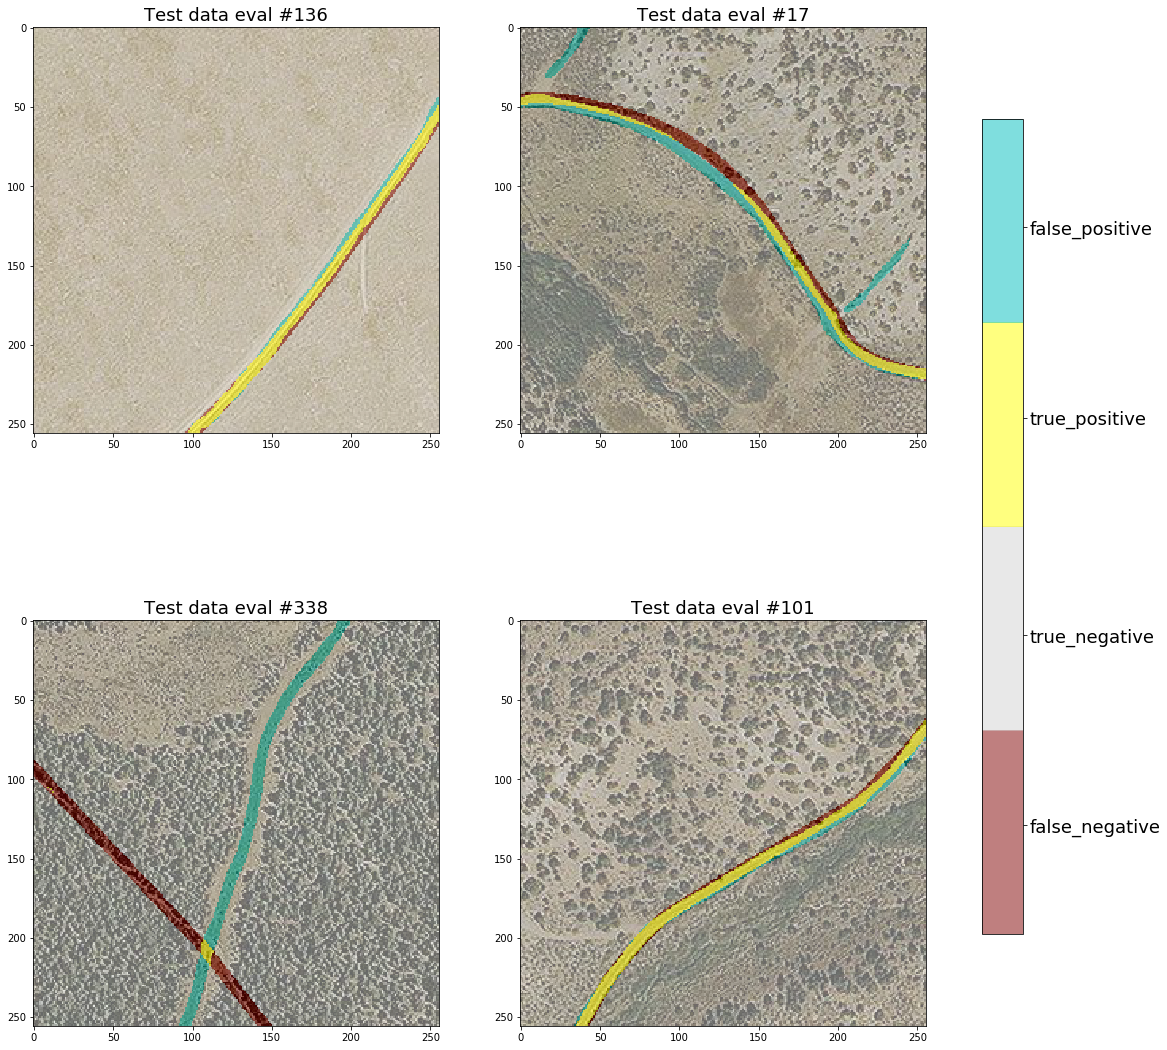

In [50]:
r, c = (2,2)
f, ax = plt.subplots(r,c, figsize=(20,20))
cmap = mpl.colors.ListedColormap(['maroon','lightgrey','yellow','c'])
for i in range(r):
    for j in range(c):
        mac, precision, recall, f1 = segtools.accuracy_summaries(y_test[samples[i,j]], \
                                                                 y_hat_test[samples[i,j]])
        ax[i,j].imshow(x_test[samples[i,j]].astype('float32'))
        im = ax[i,j].imshow(mac, cmap=cmap, alpha=0.5)
        ax[i,j].set_title('Test data eval #%s'%samples[i,j], fontsize=18)
bounds = [0.4, 1.1, 1.9, 2.6]
labels = ['false_negative', 'true_negative', 'true_positive', 'false_positive']
cb = f.colorbar(im, ax=ax.ravel().tolist(),shrink=0.75)
cb.set_ticks(bounds)
cb.set_ticklabels(labels)
cb.ax.tick_params(labelsize=18)
#f.savefig('./figures/test_eval_quad_1.png', dpi=300, bbox_inches='tight')

Normalized confusion matrix
[[ 0.98551529  0.01448471]
 [ 0.47661134  0.52338866]]


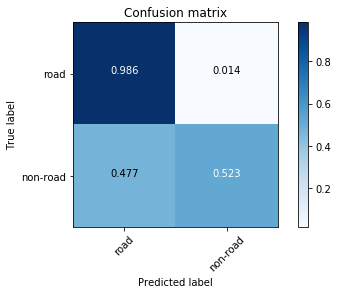

In [51]:
plot_confusion_matrix(cnf_matrix, classes=['road', 'non-road'], title='Confusion matrix', normalize=True)
#plt.savefig('./figures/test_confusion_matrix.png', dpi=600, bbox_inches='tight')